In [2]:
import os
import sys
import argparse
import distutils.core
import cv2
import matplotlib.pyplot as plt
import torch
torch.cuda.is_available()

True

In [3]:
from datasets import *
from bodyhands import *
from bodyhands import add_bodyhands_config
from bodyhands import CustomVisualizer
from detectron2.data import MetadataCatalog
from detectron2.modeling import build_model
from detectron2.config import get_cfg
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import MetadataCatalog

In [4]:
class CustomPredictor:

    def __init__(self, cfg):
        self.cfg = cfg.clone()  
        self.model = build_model(self.cfg)
        self.model.eval()
        self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        with torch.no_grad():  
            if self.input_format == "RGB":
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs], height, width)[0]
            return predictions

def prepareModel(cfg_file, weights, thresh):
    cfg = get_cfg()
    add_bodyhands_config(cfg)
    cfg.merge_from_file(cfg_file)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thresh
    cfg.MODEL.WEIGHTS = os.path.abspath(weights)
    predictor = CustomPredictor(cfg)
    return predictor

# Load bodyhands model 
model = prepareModel('./configs/BodyHands.yaml', './models/model.pth', 0.7)

In [61]:
image_path = r'D:\PuMuxin\FreiHand\orginal\naked_hands\00000527.jpg'#00000057.jpg'
im = cv2.imread(image_path)

outputs = model(im)
#######################################################################################
outputs = outputs["instances"].to("cpu")
classes = outputs.pred_classes
body_ids = outputs.pred_body_ids
boxes = outputs.pred_boxes.tensor
masks = outputs.pred_masks

hand_indices = classes == 0
hand_boxes = boxes[hand_indices]
hand_boxes

D:\Anaconda\envs\openpose-1.7.0\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[ 67.4241,  56.4791, 160.4827, 166.6847]])

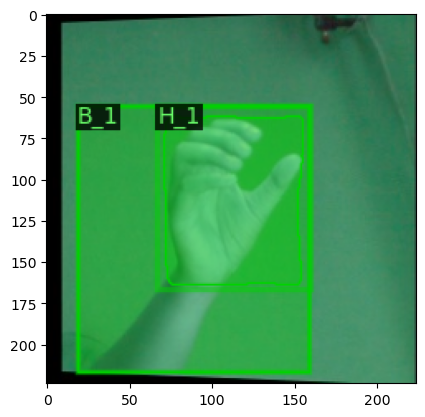

In [62]:
hand_indices = classes == 0
hand_boxes = boxes[hand_indices]
hand_body_ids = body_ids[hand_indices]
num_hands = hand_boxes.shape[0]
hand_masks = masks[hand_indices]

body_indices = classes == 1
body_boxes = boxes[body_indices]
body_body_ids = body_ids[body_indices]
num_bodies = body_boxes.shape[0]
body_masks = []

for body_no in range(num_bodies):
    box = body_boxes[body_no].view(-1).cpu().numpy()
    xmin, ymin, xmax, ymax = box
    body_poly = [[(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)]]
    body_masks.append(body_poly)
    
########################################################################################
v = CustomVisualizer(im[:, :, ::-1], MetadataCatalog.get("HandBodyContactHands_sub"), scale=1.0)
v = v.modified_draw_instance_predictions(hand_boxes, hand_masks, hand_body_ids, body_boxes, body_masks, body_body_ids)
out = v.get_image()[:, :, ::-1]
# cv2.imwrite(os.path.join(out_path, filename), out)
plt.imshow(out)
plt.show()

## Draft here, Put into hand_landmark_localisation eventually

In [58]:
# Import Openpose (Windows/Ubuntu/OSX)
dir_path = os.path.dirname(os.path.realpath('__file__'))
try:
    # Change these variables to point to the correct folder (Release/x64 etc.)
    sys.path.append(dir_path + '/../bin/python/openpose/Release');
    os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/../x64/Release;' +  dir_path + '/../bin;'
    import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e
    
def extend_hand_box(box, image_height, image_width, extend):
    xmin, ymin, xmax, ymax = box 
    for i in range(extend):
        if xmin == 0 and xmax < image_width: 
            xmax += 1
            extend += 1
        elif xmin > 0 and xmax == image_width: 
            xmin -= 1
            extend += 1
        elif xmin <= 0 and xmax >= image_width:
            pass
        else: 
            xmin, xmax = xmin - 1, xmax + 1

        if ymin == 0 and ymax < image_height: 
            ymax += 1
            extend += 1
        elif ymin > 0 and ymax == image_height:
            ymin -= 1
            extend += 1
        elif ymin <= 0 and ymax >= image_height:
            pass
        else: 
            ymin, ymax = ymin - 1, ymax + 1
    
    xmin = 0 if xmin<0 else xmin
    ymin = 0 if ymin<0 else ymin
    xmax = image_width if xmax > image_width else xmax
    ymax = image_height if ymax > image_height else ymax
    
    return xmin, ymin, xmax, ymax

def find_bounded_sqaure(box):
    xmin, ymin, xmax, ymax = box 
    x = (xmax-xmin)/2 + xmin
    y = (ymax-ymin)/2 + ymin
    extend = max(xmax-xmin, ymax-ymin)/2 
    new_xmin, new_ymin = x-extend, y-extend
    new_xmax, new_ymax = x+extend, y+extend
    return new_xmin, new_ymin, new_xmax, new_ymax

def convert_to_op_rectangle(box, image_height, image_width, extend=50):
    bounded_sqaure = find_bounded_sqaure(box)
#     print(bounded_sqaure)
    xmin, ymin, xmax, ymax = extend_hand_box(bounded_sqaure, image_height, image_width, extend)
    width = abs(xmax - xmin)
    height = abs(ymax - ymin)
    length = max(width, height)
    hand_rectangle = op.Rectangle(xmin, ymin, length, length)
    return hand_rectangle

In [59]:
hand_boxes_copy = []
for box in hand_boxes:
    box_copy = []
    for value in box: 
        box_copy.append(float(value))
    hand_boxes_copy.append(box_copy)
print("hand_boxes_copy: " + str(hand_boxes_copy))

height, width = im.shape[:2]
# We are considering every seen hand is a left hand
hands_rectangles = [[convert_to_op_rectangle(box, height, width, 30), op.Rectangle(0., 0., 0., 0.)] for box in hand_boxes_copy]
print("hands_rectangles: " + str(hands_rectangles))

hand_boxes_copy: [[65.52327728271484, 55.68765640258789, 158.0999755859375, 176.36659240722656]]
hands_rectangles: [[[21.472158, 25.687656, 180.678940, 180.678940], [0.000000, 0.000000, 0.000000, 0.000000]]]


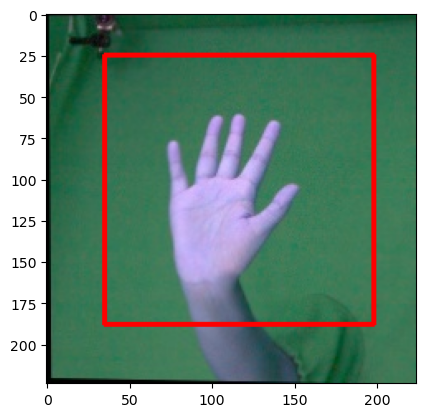

In [60]:
pre_hands_rectangles = [[[35.523277, 25.687656, 163.412323, 163.412323], [0.000000, 0.000000, 0.000000, 0.000000]]]
image = cv2.imread(image_path)

temp = image.copy()
xmin, ymin, width, height = [int(x) for x in list(pre_hands_rectangles[0][0])]
cv2.rectangle(temp, (xmin, ymin), (xmin+width, ymin+height), (255, 0, 0), 2)
    
plt.imshow(temp)
plt.show()